<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 0 - Introducción a Máquinas de Aprendizaje </H3>
<hr style="height:2px;border:none"/>

Integrantes:
- Diego Jara - 201304530-8
- Miguel Ibáñez - 2990010-8

In [52]:
import re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_absolute_error #measure MAE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer

## 2. Job Salary Prediction

** a) Lectura de data y sets **

In [2]:
df = pd.read_csv("Train_rev1.csv")

df_train = df.iloc[:-20000] # Train set
df_val = df.iloc[-10000:] # Validation set
df_test = df.iloc[-20000:-10000] # Test set

msk = np.random.rand(len(df_train)) < 0.05 # Sample del train dataset
df_train_subset = df_train[msk]

In [3]:
print("Train dataset shape:{}".format(df_train_subset.shape))
print("Test dataset shape:{}".format(df_test.shape))
print(df_train_subset.info())

Train dataset shape:(11282, 12)
Test dataset shape:(10000, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11282 entries, 18 to 224753
Data columns (total 12 columns):
Id                    11282 non-null int64
Title                 11282 non-null object
FullDescription       11282 non-null object
LocationRaw           11282 non-null object
LocationNormalized    11282 non-null object
ContractType          3110 non-null object
ContractTime          8245 non-null object
Company               9762 non-null object
Category              11282 non-null object
SalaryRaw             11282 non-null object
SalaryNormalized      11282 non-null int64
SourceName            11282 non-null object
dtypes: int64(2), object(10)
memory usage: 1.1+ MB
None


In [4]:
df_train_subset.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
18,23528672,Senior Fatigue and Damage Tolerance Engineer,Senior Fatigue Static stress (metallic or comp...,"Avon, South West",Avon,NaN,permanent,Gregory Martin International,Engineering Jobs,34000 - 45000/annum to 45K,39500,cv-library.co.uk
22,24835524,Senior Control and Instrumentation Engineer,Senior Control and Instrumentation Engineer . ...,"Berkshire, South East",Berkshire,NaN,permanent,Gregory Martin International,Engineering Jobs,36000 - 47000/annum 36K-47K,41500,cv-library.co.uk
49,29571632,"Bar/Waiting Staff The Refectory, Godalming","We are looking for outgoing, friendly people t...","Milford, Surrey",Milford,NaN,permanent,Brunning & Price,Travel Jobs,6.08 per hour,11673,leisurejobs.com
85,34061974,Senior Mechanical Engineer (Water),Senior Mechanical Engineer (Water) We are curr...,"Avon, South West",Avon,NaN,permanent,Gregory Martin International,Engineering Jobs,32000 - 41000/annum 32K to 41K + benefits,36500,cv-library.co.uk
155,44325443,New Business Sales Various Financial Markets...,Excelsior Professional Search is a leading exe...,London,London,NaN,NaN,Excelsior Professional Search Ltd,Accounting & Finance Jobs,"Basic salaries range from 50,000 to 90,000 + C...",70000,eFinancialCareers


**b) Extracción de datos**

In [5]:
txt_raw_train = df_train_subset.FullDescription
txt_raw_val = df_val.FullDescription
txt_raw_test = df_test.FullDescription

salary_train = np.asarray(df_train_subset["SalaryNormalized"])
salary_val = np.asarray(df_val["SalaryNormalized"])
salary_test = np.asarray(df_test["SalaryNormalized"])

**c) Pre-procesamiento**

In [6]:
def word_extractor(text):
    wordlemmatizer = WordNetLemmatizer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower())for word in word_tokenize(text) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words

In [7]:
texts_train = [word_extractor(text) for text in txt_raw_train]
texts_val = [word_extractor(text) for text in txt_raw_val]

vectorizer1 = CountVectorizer()
vectorizer1.fit(np.asarray(texts_train))

features_train = vectorizer1.transform(texts_train)
features_val = vectorizer1.transform(texts_val)

**d) Regresión**

In [8]:
model = LR(fit_intercept=True, normalize=False)
model.fit(features_train,salary_train)

LR_fo = lambda x,y: sum((x-y)**2)
print("F.O. on train: ",LR_fo(salary_train, model.predict(features_train)))
print("F.O. on validation: ",LR_fo(salary_val, model.predict(features_val)))
print()

print("MAE on train: ",mean_absolute_error(salary_train, model.predict(features_train)))
print("MAE on validation: ",mean_absolute_error(salary_val, model.predict(features_val)))

F.O. on train:  657784696.644
F.O. on validation:  7.4482530436e+12

MAE on train:  8.63222102321
MAE on validation:  19752.599748


## 3. Linear Regression by hand

**a)** Función de pérdida: error cuadrático medio

In [212]:
def MSE(b,X,y):
    m = len(y)
    predicciones = X.dot(b)
    costo = (1/2*m) * np.sum(np.square(predicciones-y))
    return costo

**b)** Gradiente

In [217]:
def gradient(X,y,b,m):
    prediccion = np.dot(X,b)
    e = prediccion - y
    g = np.dot(X.T,e)
    return g/m

**c)** Regresión lineal analitica

In [214]:
# se puede hacer en una línea pero es muy enredado
def analytic_LR (Y,X):
    a = np.dot(X.T,X)         # (X^T)X
    b = np.linalg.inv(a)      # ((X^T)X)^-1
    c = np.dot(b,X.T)         # (((X^T)X)^-1)(X^T)
    bgorro = np.dot(c,Y)      # ((((X^T)X)^-1)(X^T))Y = beta gorro
    return bgorro

**d)** Regresión lineal por Stochastic Gradient Descend (SGD)

In [218]:
def SGD(X,y,b,eta,N):
    m = len(y)
    costos = np.zeros(N)
    
    for iteracion in range(N):
        costo = 0.0
        for i in range(m):
            rand_ind = np.random.randint(0,m)
            X_i = X[rand_ind,:].reshape(1,X.shape[1])
            y_i = y[rand_ind].reshape(1,1)
            prediccion = np.dot(X_i,b)

            b = b - eta*gradient(X_i,y_i,b,m)
            costo += MSE(b,X_i,y_i)
            
        costos[iteracion] = costo
    return [b, costos]

**e)** Análisis dataset **Boston Housing**

In [219]:
from sklearn.datasets import load_boston
X_train,y_train = load_boston(return_X_y=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Forma analitica
t1=time.time()
b_analitica = analytic_LR(Y,X)
t2=time.time()
tiempo_analitica = float(t2-t1)

# Gradiente descendente
b0 = np.random.randn(X_train.shape[1],)
iteraciones = 1000
eta = 0.01
t1=time.time()
b_sgd, costos = SGD(X_train, y_train, b0, eta, iteraciones)
t2=time.time()
tiempo_sgd = float(t2-t1)

print(tiempo_analitica)
print(tiempo_sgd)

0.0
20.137112379074097


In [220]:
print(b_analitica)
print(b_sgd[0])

[-0.92041113  1.08098058  0.14296712  0.68220346 -2.06009246  2.67064141
  0.02112063 -3.10444805  2.65878654 -2.07589814 -2.06215593  0.85664044
 -3.74867982]
[-0.81994885 -0.78130329 -0.84253473 -0.80129555 -0.79246101 -0.78576597
 -0.81374757 -0.78608379 -0.78334244 -0.83633938 -0.80852487 -0.78975903
 -0.79632391]


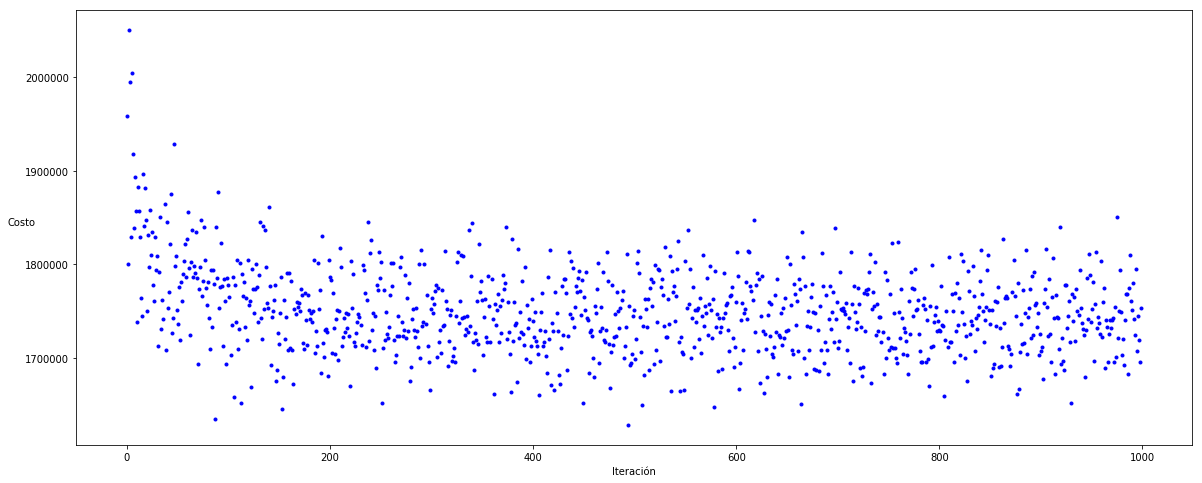

In [221]:
fig,ax = plt.subplots(figsize=(20,8))

ax.set_ylabel('Costo',rotation=0)
ax.set_xlabel('Iteración')

_=ax.plot(range(iteraciones),costos,'b.')